In [20]:
# !pip install git+https://github.com/AAMIASoftwares-research/HCATNetwork.git@google-colab
# !pip install git+https://github.com/AAMIASoftwares-research/DatasetUtilities.git@google-colab

In [21]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcatnetwork
import HearticDatasetManager
import numpy as np

In [22]:
# Set folder paths
ASOCA_FOLDER = "C:/Users/zaira/Documents/uni/HIGH_PERFORMANCE_COMPUTING/Neuroengineering/project/heart_data/ASOCA/"
CAT08_FOLDER = "C:/Users/zaira/Documents/uni/HIGH_PERFORMANCE_COMPUTING/Neuroengineering/project/heart_data/CAT08/"

In [23]:
# open image
image_file = os.path.join(
    ASOCA_FOLDER,
    HearticDatasetManager.asoca.DATASET_ASOCA_IMAGES_DICT["Normal"][1] 
)
image = HearticDatasetManager.asoca.AsocaImageCT(image_file)

# open graph 
graph_file = os.path.join(
    ASOCA_FOLDER,
    HearticDatasetManager.asoca.DATASET_ASOCA_GRAPHS_RESAMPLED_05MM_DICT["Normal"][1]
)
graph = hcatnetwork.io.load_graph(
    graph_file,
    output_type=hcatnetwork.graph.SimpleCenterlineGraph
)


Plot the graph in 2D, using the built-in function:

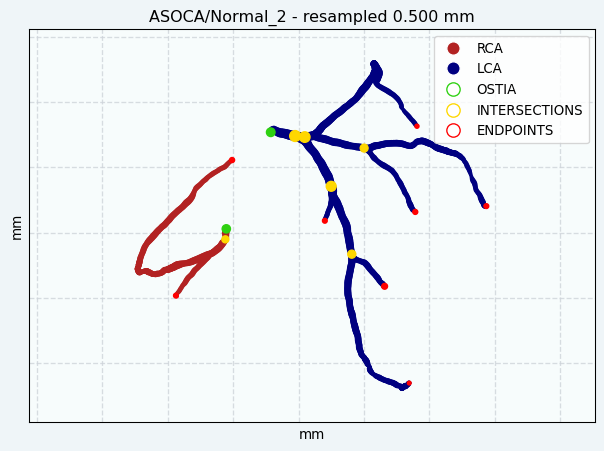

In [24]:
import os
from hcatnetwork.io.io import load_graph
from hcatnetwork.draw.draw import draw_simple_centerlines_graph_2d
draw_simple_centerlines_graph_2d(graph, backend="networkx")

Plot the graph in 3D: I haven't found a way to plot it in 3D using their libraries

In [25]:
# select Ostium coordinates and save radius
ids = graph.get_coronary_ostia_node_id()
coord_ostium_1 = np.array([graph.nodes[ids[0]]['x'],graph.nodes[ids[0]]['y'],graph.nodes[ids[0]]['z'],np.array([graph.nodes[ids[0]]['r']])])
coord_ostium_2 = np.array([graph.nodes[ids[1]]['x'],graph.nodes[ids[1]]['y'],graph.nodes[ids[1]]['z'],np.array([graph.nodes[ids[1]]['r']])])


C:\Users\zaira\AppData\Local\Temp\ipykernel_9412\2172319419.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coord_ostium_1 = np.array([graph.nodes[ids[0]]['x'],graph.nodes[ids[0]]['y'],graph.nodes[ids[0]]['z'],np.array([graph.nodes[ids[0]]['r']])])
C:\Users\zaira\AppData\Local\Temp\ipykernel_9412\2172319419.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coord_ostium_2 = np.array([graph.nodes[ids[1]]['x'],graph.nodes[ids[1]]['y'],graph.nodes[ids[1]]['z'],np.array([graph.nodes[ids[1]]['r']])])


<Figure size 1200x800 with 0 Axes>

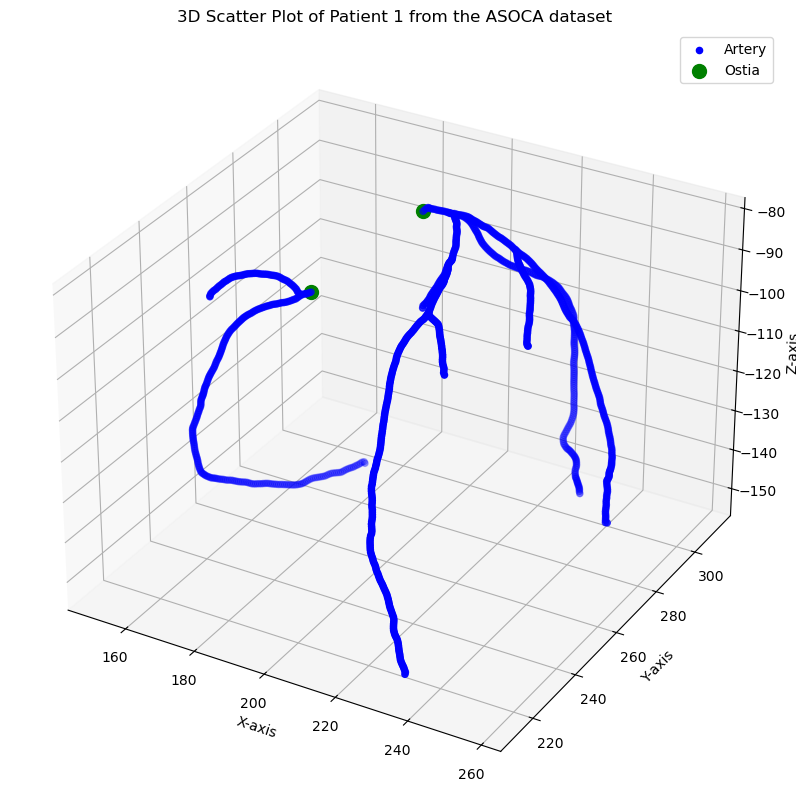

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting toolkit

data_points = len(graph.nodes)

x_coords=[]
y_coords=[]
z_coords=[]
fig = plt.figure(figsize=(12, 8))
for node_id in graph.nodes:
    coords = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    x_coords.append(coords[0])
    y_coords.append(coords[1])
    z_coords.append(coords[2])

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(x_coords, y_coords, z_coords, c='blue', marker='o', s=20)
ax.scatter(coord_ostium_1[0], coord_ostium_1[1], coord_ostium_1[2], c='green', marker='o', s=100)
ax.scatter(coord_ostium_2[0], coord_ostium_2[1], coord_ostium_2[2], c='green', marker='o', s=100)


# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set title
ax.set_title('3D Scatter Plot of Patient 1 from the ASOCA dataset')

# Set legend
ax.legend(["Artery", "Ostia"], loc ="best")

plt.show()


In [27]:
# extract a cube from the original image
CUBE_SIDE_MM = 24
CUBE_ISOTROPIC_SPACING_MM = 0.5
CUBE_SIDE_N_SAMPLES = int(CUBE_SIDE_MM * (1/CUBE_ISOTROPIC_SPACING_MM))
NUM_CUBES_PATIENT = 500

In [28]:
# find min, max and avg radius in graph
minR = 10
maxR = 0
avgR = 0
for node_id in graph.nodes:
    r = graph.nodes[node_id]["r"]
    avgR += r
    if(r>maxR): maxR=r
    elif(r<minR): minR = r
        
avgR /= len(graph.nodes)

print(f'Min Radius: {minR}')
print(f'Max Radius: {maxR}')
print(f'Avg Radius: {avgR}')

Min Radius: 0.26122156230372007
Max Radius: 2.251113897698272
Avg Radius: 0.9808494702461318


In [29]:
# convert graph coordinates to RAS right away
x_vessels= []
y_vessels= []
z_vessels= []
for node_id in graph.nodes:
    old_coords = np.array(
        [graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]]
    )
    x_vessels.append(old_coords[0])
    y_vessels.append(old_coords[1])
    z_vessels.append(old_coords[2])
    new_coords = HearticDatasetManager.affine.apply_affine_3d(image.affine_centerlines2ras, old_coords)
    graph.nodes[node_id]["x"] = new_coords[0]   
    graph.nodes[node_id]["y"] = new_coords[1]
    graph.nodes[node_id]["z"] = new_coords[2]

coords_o1=coord_ostium_1[:-1]
coords_o2=coord_ostium_2[:-1]
coord_ostium_1_ras = HearticDatasetManager.affine.apply_affine_3d(image.affine_centerlines2ras, coords_o1)
coord_ostium_2_ras = HearticDatasetManager.affine.apply_affine_3d(image.affine_centerlines2ras, coords_o2)

In [30]:
# extract a cube from the original image
CUBE_SIDE_MM = 24
CUBE_ISOTROPIC_SPACING_MM = 0.5
CUBE_SIDE_N_SAMPLES = int(CUBE_SIDE_MM * (1/CUBE_ISOTROPIC_SPACING_MM))
NUM_CUBES_PATIENT = 500

In [31]:
# generates coordinate matrices from x,y,z sampled points. Flattening and trasposing is then performed to generate (Nx3) arrays
def get_cube_sample_points(center: np.ndarray, side_mm: float, n_samples_per_side: int):
    """Sample a cube centered in center with side side, n_samples points."""
    xs = np.linspace(center[0] - side_mm/2, center[0] + side_mm/2, n_samples_per_side)
    ys = np.linspace(center[1] - side_mm/2, center[1] + side_mm/2, n_samples_per_side)
    zs = np.linspace(center[2] - side_mm/2, center[2] + side_mm/2, n_samples_per_side)
    return np.array(np.meshgrid(xs, ys, zs)).reshape(3, -1).T

# returns samples as a (NxNxN) array
def cube_samples_to_array(samples: np.ndarray, n_samples_per_side: int) -> np.ndarray:
    """Convert samples from a cube to a numpy array."""
    return samples.reshape(n_samples_per_side, n_samples_per_side, n_samples_per_side)

# returns directly the cube as numpy (NxNxN) array from center point in RAS coordinates
def get_input_data_from_vertex_ras_position(
        image: HearticDatasetManager.cat08.Cat08ImageCT|HearticDatasetManager.asoca.AsocaImageCT,
        position: np.ndarray,
        side_mm: float,
        n_samples_per_side: int,
        affine=np.eye(4)
    ) -> np.ndarray:
    """Get the input data from a vertex position expressed in RAS coordinates system.

    Parameters
    ----------
    image : HearticDatasetManager.cat08.Cat08ImageCT | HearticDatasetManager.asoca.AsocaImageCT
        The image from which to extract the data.
    position : numpy.ndarray
        The position of the cube center in RAS coordinates system.
    side_mm : float
        The side of the cube in mm.
    n_samples_per_side : int
        The number of samples per side.
    affine : np.ndarray, optional
        The affine transformation to apply to the position of the samples used to create the cube, by default np.eye(4) (which does nothing).
        This is useful in data augmemtation, if you want to rotate, flip, or do whatever operation
        on the cube sample points, you can do it by passing the affine transformation here.
        For example, HearticDatasetManager.affine.get_affine_3d_rotation_around_vector() will rotate the cube (see the function docs).
    """
    # Get the cube sample points
    cube_pos = get_cube_sample_points(position, side_mm, n_samples_per_side)
    # Apply transformation affine if any
    if affine is None:
        affine = np.eye(4)
    cube_pos = HearticDatasetManager.affine.apply_affine_3d(affine, cube_pos)
    # Sample the image
    samples = image.sample(cube_pos, interpolation="linear").T
    # Convert to ndarray
    cube_array = cube_samples_to_array(samples, n_samples_per_side)
    return cube_array

Generation of random nodes from the artery

In [32]:
# define lists to save patches and corresponding labels
cubes = []
labels = []
i_coords=[]
j_coords=[]
k_coords=[]
x_ras_coords=[]
y_ras_coords=[]
z_ras_coords=[]

# firstly random sample along the graph
for cube_i in range(NUM_CUBES_PATIENT//2):
    # choose a random node of the graph
    node_id = np.random.choice(list(graph.nodes.keys()))
    # get the position of the node in RAS
    node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    # select parameters for random translation
    r = np.random.uniform(0, avgR*1.5)#translation vector
    theta = np.random.uniform(0, 2*np.pi)#xy plane angle
    phi = np.random.uniform(0, np.pi)#z to xy plane angle
    # apply the translation to the selected point
    node_position += np.array([r*np.sin(phi)*np.cos(theta), r*np.sin(phi)*np.sin(theta), r*np.cos(phi)]).reshape(3,1)
    x_ras_coords.append(node_position[0])
    y_ras_coords.append(node_position[1])
    z_ras_coords.append(node_position[2])
    ijk_coords = HearticDatasetManager.affine.apply_affine_3d(image.affine_ras2ijk, node_position)
    i_coords.append(ijk_coords[0])
    j_coords.append(ijk_coords[1])
    k_coords.append(ijk_coords[2])
    # print(ijk_coords)

    cube_array = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)
    # compute distances from ostia to assign labels
    dist1 = np.sqrt(np.sum(np.square(coord_ostium_1[:3]-node_position)))
    dist2 = np.sqrt(np.sum(np.square(coord_ostium_2[:3]-node_position)))
    label = 1 if (dist1<=1.2*coord_ostium_1[-1] or dist2<=1.2*coord_ostium_2[-1]) else 0
    
    cubes.append(cube_array)
    labels.append(label)
    
cubes = np.array(cubes)
labels = np.array(labels)

<Figure size 1200x800 with 0 Axes>

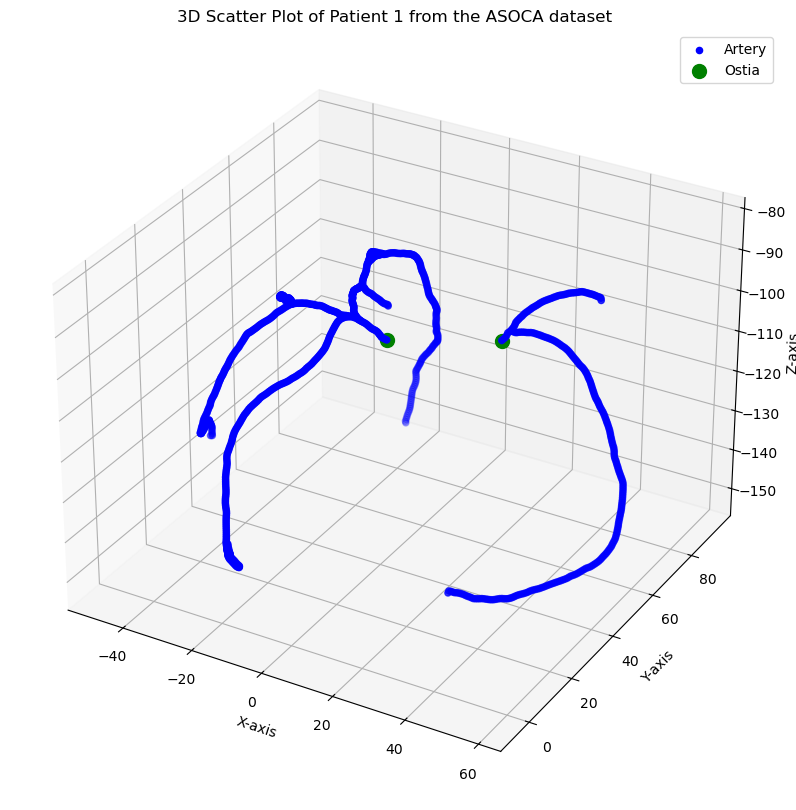

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting toolkit

data_points = len(graph.nodes)

x_coords=[]
y_coords=[]
z_coords=[]
fig = plt.figure(figsize=(12, 8))
for node_id in graph.nodes:
    coords = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    x_coords.append(coords[0])
    y_coords.append(coords[1])
    z_coords.append(coords[2])

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(x_coords, y_coords, z_coords, c='blue', marker='o', s=20)
ax.scatter(coord_ostium_1_ras[0], coord_ostium_1_ras[1], coord_ostium_1_ras[2], c='green', marker='o', s=100)
ax.scatter(coord_ostium_2_ras[0], coord_ostium_2_ras[1], coord_ostium_2_ras[2], c='green', marker='o', s=100)




# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set title
ax.set_title('3D Scatter Plot of Patient 1 from the ASOCA dataset')

# Set legend
ax.legend(["Artery", "Ostia"], loc ="best")

plt.show()


<Figure size 1200x800 with 0 Axes>

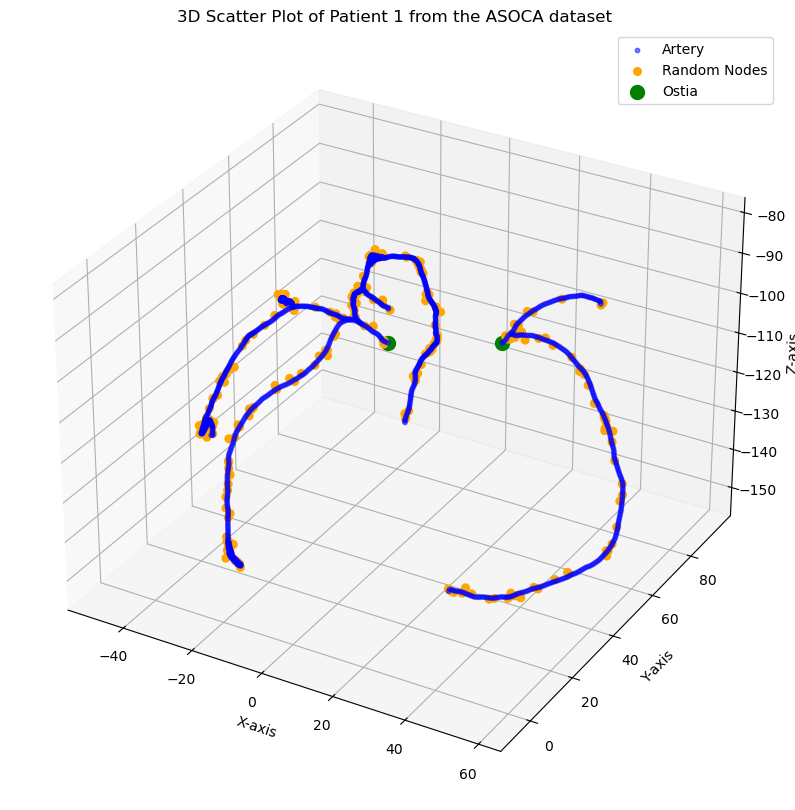

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting toolkit

data_points = len(graph.nodes)

x_coords=[]
y_coords=[]
z_coords=[]

fig = plt.figure(figsize=(12, 8))
for node_id in graph.nodes:
    coords = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
    x_coords.append(coords[0])
    y_coords.append(coords[1])
    z_coords.append(coords[2])

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(x_coords, y_coords, z_coords, c='blue', marker='o', s=10, label='Artery', alpha = 0.5) #vessels in ras (the same as the blue ones, taken in a different loop bit in the same way)
ax.scatter(x_ras_coords, y_ras_coords, z_ras_coords, c='orange', marker='o', s=30, label='Random Nodes', alpha = 1, zorder=10) #random points in ras taken after random translation of the random points
ax.scatter(coord_ostium_1_ras[0], coord_ostium_1_ras[1], coord_ostium_1_ras[2], c='green', marker='o', s=100, label='Ostia', alpha=1, zorder=10)
ax.scatter(coord_ostium_2_ras[0], coord_ostium_2_ras[1], coord_ostium_2_ras[2], c='green', marker='o', s=100, alpha=1, zorder=10)



# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set title
ax.set_title('3D Scatter Plot of Patient 1 from the ASOCA dataset')

# Set legend
ax.legend( loc ="best")
plt.show()

Quello che viene ora serve solo se volete plottare anche tutti i punti che prendiamo a partire dal centro dei due ostia.. secondo me ha poco senso perchè va semplicemente a plottare intorno a dove è già verde

In [35]:
# from HearticDatasetManager.affine import compose_affines, apply_affine_3d
# from HearticDatasetManager.image import ImageCT
# from HearticDatasetManager.asoca import AsocaImageCT

# graph_coordinates=[]
# graph_coordinates.append(x_coords)
# graph_coordinates.append(y_coords)
# graph_coordinates.append(z_coords)

# graph_coordinates=np.array(graph_coordinates)
# ijk_graph_coords=HearticDatasetManager.affine.ras2ijk(graph_coordinates)

In [36]:
# # reconvert to list
# cubes = list(cubes)
# labels = list(labels)

In [37]:
# # then sample locally from the ostia
# angles = [-20, -10, -5, 5, 10, 20]
# for cube_i in range(NUM_CUBES_PATIENT//2):
#     # select one of the two ostia
#     node_id = np.random.choice(ids)
#     # get the position of the node in RAS
#     node_position = np.array([graph.nodes[node_id]["x"], graph.nodes[node_id]["y"], graph.nodes[node_id]["z"]])
#     # select parameters for random translation
#     r = np.random.uniform(-graph.nodes[node_id]["r"]*1.2, graph.nodes[node_id]["r"]*1.2)#translation vector
#     theta = np.random.uniform(0, 2*np.pi)#xy plane angle
#     phi = np.random.uniform(0, np.pi)#z to xy plane angle
#     # apply the translation to the selected point
#     node_position += np.array([r*np.sin(phi)*np.cos(theta), r*np.sin(phi)*np.sin(theta), r*np.cos(phi)]).reshape(3,1)
#     cube_array = get_input_data_from_vertex_ras_position(image,node_position,CUBE_SIDE_MM,CUBE_SIDE_N_SAMPLES)
#     # compute distances from ostia to assign labels
#     dist1 = np.sqrt(np.sum(np.square(coord_ostium_1[:3]-node_position)))
#     dist2 = np.sqrt(np.sum(np.square(coord_ostium_2[:3]-node_position)))
#     label = 1 if (dist1<=1.2*coord_ostium_1[-1] or dist2<=1.2*coord_ostium_2[-1]) else 0
    
#     # fare data augmentation qui
  
#     cubes.append(cube_array)
#     labels.append(label)
    
# cubes = np.array(cubes)
# labels = np.array(labels)
